In [1]:
import pandas as pd
import numpy as np
import calendar
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
# High-cardinality encoder (fast, memory-safe)
from category_encoders.hashing import HashingEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer  # (kept for template; we do not have nulls)
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, recall_score
from sklearn.metrics import average_precision_score
from category_encoders import TargetEncoder


In [2]:
#data = pd.read_csv('Semi_time_scaled_data.csv')

### Data Loading and Quick Checks

In [3]:
#data = pd.read_csv('eda_dataset.csv')
data = pd.read_csv('eda_dataset_withdate_time.csv')

In [4]:
data.head()

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,...,is_fraud,tr_year,tr_month,tr_day,tr_hour,tr_minute,age,age_group,tr_day_name,distance_cust_merchant_km
0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,...,0,2019,1,1,0,0,31,adult,Tuesday,78.60
1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,...,0,2019,1,1,0,0,41,adult,Tuesday,30.21
2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,...,0,2019,1,1,0,0,57,senior,Tuesday,108.21
3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,Boulder,...,0,2019,1,1,0,1,52,senior,Tuesday,95.67
4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,Doe Hill,...,0,2019,1,1,0,3,33,adult,Tuesday,77.56


In [5]:
data["merchant"] = data["merchant"].str.replace("^fraud_", "", regex=True)

In [6]:
data["amt_log"] = np.log1p(data["amt"])

In [7]:
data["is_weekend"] = (data["tr_day"] >= 5).astype(int)

In [8]:
data["is_night"] = ((data["tr_hour"] <= 5) | (data["tr_hour"] >= 22)).astype(int)

In [9]:
#Groups by each card (cc_num)
# For each card, uses a 24-hour rolling window based on the column trans_date_trans_time
# Counts transactions in last 24 hours
# Returns a Series aligned to your original rows

data["trans_date_trans_time"] = pd.to_datetime(data["trans_date_trans_time"], errors="coerce")
data = data.sort_values(["cc_num", "trans_date_trans_time"])

data["txns_last_24h"] = (
    data.groupby("cc_num", group_keys=False)
        .apply(lambda g: g.rolling("24h", on="trans_date_trans_time")["trans_date_trans_time"].count())
        .reset_index(level=0, drop=True)
)


C:\Users\patid\AppData\Local\Temp\ipykernel_8968\4166247647.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.rolling("24h", on="trans_date_trans_time")["trans_date_trans_time"].count())


In [10]:
#rolling mean amount + deviation feature
data = data.sort_values(["cc_num", "trans_date_trans_time"])

# Compute the rolling mean transaction amount for each card
# using the last ~20 transactions to capture normal spending behavior.
data["amt_mean_20"] = (
    data.groupby("cc_num")["amt"]
        .transform(lambda s: s.rolling(window=20, min_periods=3).mean())
)


# Fill missing rolling means (early transactions) with global median
# to avoid null values and keep the feature model-safe.
data["amt_mean_20"] = data["amt_mean_20"].fillna(data["amt"].median())


# Measure how unusual the current transaction amount is
# compared to the card’s recent average spending.
data["amt_vs_mean_ratio"] = data["amt"] / (data["amt_mean_20"] + 1e-6)

In [11]:
data.head()

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,...,age,age_group,tr_day_name,distance_cust_merchant_km,amt_log,is_weekend,is_night,txns_last_24h,amt_mean_20,amt_vs_mean_ratio
1017,2019-01-01 12:47:15,60416207185,"Jones, Sawayn and Romaguera",misc_net,7.27,Mary,Diaz,F,9886 Anita Drive,Fort Washakie,...,33,adult,Tuesday,127.61,2.112635,0,0,5.0,47.450,0.153214
2724,2019-01-02 08:44:57,60416207185,Berge LLC,gas_transport,52.94,Mary,Diaz,F,9886 Anita Drive,Fort Washakie,...,33,adult,Wednesday,110.31,3.987872,0,0,7.0,47.450,1.115701
2726,2019-01-02 08:47:36,60416207185,Luettgen PLC,gas_transport,82.08,Mary,Diaz,F,9886 Anita Drive,Fort Washakie,...,33,adult,Wednesday,21.79,4.419804,0,0,6.0,47.430,1.730550
2882,2019-01-02 12:38:14,60416207185,Daugherty LLC,kids_pets,34.79,Mary,Diaz,F,9886 Anita Drive,Fort Washakie,...,33,adult,Wednesday,87.20,3.577669,0,0,5.0,44.270,0.785859
2907,2019-01-02 13:10:46,60416207185,Beier and Sons,home,27.18,Mary,Diaz,F,9886 Anita Drive,Fort Washakie,...,33,adult,Wednesday,74.21,3.338613,0,0,2.0,40.852,0.665328


In [12]:
data.columns

Index(['trans_date_trans_time', 'cc_num', 'merchant', 'category', 'amt',
       'first', 'last', 'gender', 'street', 'city', 'state', 'zip', 'lat',
       'long', 'city_pop', 'job', 'dob', 'trans_num', 'unix_time', 'merch_lat',
       'merch_long', 'is_fraud', 'tr_year', 'tr_month', 'tr_day', 'tr_hour',
       'tr_minute', 'age', 'age_group', 'tr_day_name',
       'distance_cust_merchant_km', 'amt_log', 'is_weekend', 'is_night',
       'txns_last_24h', 'amt_mean_20', 'amt_vs_mean_ratio'],
      dtype='object')

In [13]:
data.shape

(1852394, 37)

In [14]:
data.columns

Index(['trans_date_trans_time', 'cc_num', 'merchant', 'category', 'amt',
       'first', 'last', 'gender', 'street', 'city', 'state', 'zip', 'lat',
       'long', 'city_pop', 'job', 'dob', 'trans_num', 'unix_time', 'merch_lat',
       'merch_long', 'is_fraud', 'tr_year', 'tr_month', 'tr_day', 'tr_hour',
       'tr_minute', 'age', 'age_group', 'tr_day_name',
       'distance_cust_merchant_km', 'amt_log', 'is_weekend', 'is_night',
       'txns_last_24h', 'amt_mean_20', 'amt_vs_mean_ratio'],
      dtype='object')

In [15]:
# data_c = data.select_dtypes(include=['object','category'])
# for c in data_c:
#     print( c ,':',data_c[c].nunique())

In [16]:
# data_n = data.select_dtypes(include=['number'])
# for c in data_n:
#     print( c ,':',data_n[c].nunique())

In [17]:

# data = data.drop(columns = ['trans_date_trans_time','cc_num','first', 'last','street','lat', 'long','dob','trans_num','unix_time','merch_lat', 'merch_long',
#                            'age_group','tr_day_name','city','zip','merchant','tr_year'],axis=1)
# cols_to_drop = ["cc_num","trans_num","unix_time","first","last","street","merchant","job","city","state","zip","category","gender","trans_date_trans_time",
#                 "tr_year","tr_minute","tr_day_name","lat","long","merch_lat","merch_long","age_group","dob","amt"]

cols_to_drop = [
    "cc_num","trans_num","unix_time","first","last","street",
    "merchant","job","city","state","zip","category","gender",
    "trans_date_trans_time","tr_year","tr_minute","tr_day_name",
    "lat","long","merch_lat","merch_long",
    "age_group","dob","amt",
    "tr_day","tr_month"   # drop raw calendar splits to reduce memorization
]

data = data.drop(columns=cols_to_drop, errors="ignore")
#data = data.drop(columns=cols_to_drop, errors="ignore")

In [18]:
data.shape

(1852394, 11)

In [19]:
data.columns

Index(['city_pop', 'is_fraud', 'tr_hour', 'age', 'distance_cust_merchant_km',
       'amt_log', 'is_weekend', 'is_night', 'txns_last_24h', 'amt_mean_20',
       'amt_vs_mean_ratio'],
      dtype='object')

### Train/Test Split

In [20]:
# STEP 1: Reduce from 1.8M to 100K while keeping original ratio
data_small, _ = train_test_split(data,train_size=100_000,stratify=data['is_fraud'],random_state=42)

# Check ratio preserved
print(data_small['is_fraud'].value_counts(normalize=True))

is_fraud
0    0.99479
1    0.00521
Name: proportion, dtype: float64


### Feature Engineering — Cyclic Time Encoding

In [21]:
#Cyclic Encoding of Time-Based Features
# def add_cyclic_features(df):

#     df["tr_month_sin"]  = np.sin(2*np.pi*df["tr_month"]/12)
#     df["tr_month_cos"]  = np.cos(2*np.pi*df["tr_month"]/12)

#     df["tr_day_sin"]    = np.sin(2*np.pi*df["tr_day"]/31)
#     df["tr_day_cos"]    = np.cos(2*np.pi*df["tr_day"]/31)

#     df["tr_hour_sin"]   = np.sin(2*np.pi*df["tr_hour"]/24)
#     df["tr_hour_cos"]   = np.cos(2*np.pi*df["tr_hour"]/24)

#     df["tr_minute_sin"] = np.sin(2*np.pi*df["tr_minute"]/60)
#     df["tr_minute_cos"] = np.cos(2*np.pi*df["tr_minute"]/60)
    
#     df = df.drop(columns=["tr_month", "tr_day", "tr_hour", "tr_minute"])

#     return df

# data_small = add_cyclic_features(data_small)

In [22]:
# STEP 2: Now do real modeling train/test split
X = data_small.drop(columns=['is_fraud'])
y = data_small['is_fraud']

X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, stratify=y,random_state=42)
print("Train ratio:", y_train.mean())
print("Test ratio:", y_test.mean())

Train ratio: 0.0052125
Test ratio: 0.0052


In [23]:
X_train

,city_pop,tr_hour,age,distance_cust_merchant_km,amt_log,is_weekend,is_night,txns_last_24h,amt_mean_20,amt_vs_mean_ratio
10370,184,8,74,83.12,2.243896,0,0,3.0,43.4590,0.193976
951816,1274,3,71,109.39,0.963174,0,1,3.0,52.7165,0.030730
1488483,2206,15,34,69.56,3.816393,0,0,6.0,51.5440,0.862176
15941,95,10,25,82.89,4.258870,0,0,6.0,118.5205,0.588337
1281193,4198,15,19,42.45,2.070653,0,0,3.0,71.0560,0.097529
...,...,...,...,...,...,...,...,...,...,...
910656,310,5,41,88.69,1.932970,1,1,3.0,49.2575,0.119982
1157235,2092,17,58,70.81,0.959350,0,0,3.0,74.8820,0.021500
1027256,12335,21,33,115.08,5.579126,1,0,12.0,74.8380,3.525482
695931,67082,7,56,49.30,1.985131,0,0,7.0,64.3805,0.097545


In [24]:
print(data_small.shape)

(100000, 11)


In [25]:
data_small.columns

Index(['city_pop', 'is_fraud', 'tr_hour', 'age', 'distance_cust_merchant_km',
       'amt_log', 'is_weekend', 'is_night', 'txns_last_24h', 'amt_mean_20',
       'amt_vs_mean_ratio'],
      dtype='object')

Data Sampling by maintaning (nonfraud to fraud 10:1 ratio)

In [26]:
target = 'is_fraud'

numeric_base = ['city_pop','tr_hour', 'age', 'distance_cust_merchant_km',
       'amt_log', 'is_weekend', 'is_night', 'txns_last_24h', 'amt_mean_20',
       'amt_vs_mean_ratio']
#numeric_base = ['city_pop','tr_month','tr_day','tr_hour','age','distance_cust_merchant_km','amt_log'] #'age','distance_cust_merchant_km','amt','city_pop'

#low_card_cat = ['category']
#low_card_cat = ['category', 'gender', 'state']
 
#low_card_cat= ["tr_month", "tr_day", "tr_hour", "tr_minute",'category', 'gender', 'state']
#high_card_cat = ['city']
#high_card_cat = [ 'job'] #'merchant', 'city', 'zip'this are redundant columns


#cyclic_cols = ['tr_month_sin','tr_month_cos','tr_day_sin','tr_day_cos','tr_hour_sin','tr_hour_cos','tr_minute_sin','tr_minute_cos']
all_numeric = numeric_base #+ #cyclic_cols

# data = data.drop(columns = ['cc_num','first', 'last','street','lat', 'long','dob','trans_num','unix_time','merch_lat', 'merch_long',
#                            'age_group','tr_day_name','amt_clean', 'city','zip','merchant'],axis=1)

In [27]:
#Step 1 – Transformers
from sklearn.preprocessing import OrdinalEncoder

numeric_tranformer = Pipeline(steps = [('scaler', StandardScaler())])
low_cat_transformer = Pipeline(steps = [('ohe', OneHotEncoder(handle_unknown ='ignore',sparse_output=False))])



In [28]:

preprocess_non_tree = ColumnTransformer(transformers = [
    ('num',numeric_tranformer,all_numeric)], remainder = 'drop')
# keep sin/cos, no scaling
#  remainder = 'drop' :Drop all columns that are not mentioned in the transformers list. and viceversa remainder='passthrough'

### Model Training - Logistic Regression

In [29]:
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
log_reg  = LogisticRegression(
    solver="saga",
    penalty="l2",
    C=0.1,
    class_weight="balanced",
    max_iter=1000,
    n_jobs=-1,
    random_state=42
)

pipe_non_tree = Pipeline(steps=[
    ('preprocess', preprocess_non_tree),
    ('smote', SMOTE(sampling_strategy=0.10, random_state=42,k_neighbors=2)),
    ('model', log_reg)
])
# sampling_strategy=0.10 : Minority class will be increased to 10% of the majority class

recall_score 0.9230769230769231
              precision    recall  f1-score   support

           0       1.00      0.93      0.96     19896
           1       0.07      0.92      0.12       104

    accuracy                           0.93     20000
   macro avg       0.53      0.93      0.54     20000
weighted avg       0.99      0.93      0.96     20000

ROC_AUC: 0.9748340408586186


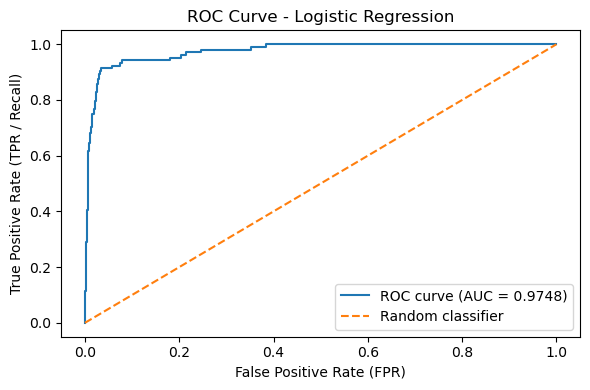

PR-AUC: 0.29106781187469455


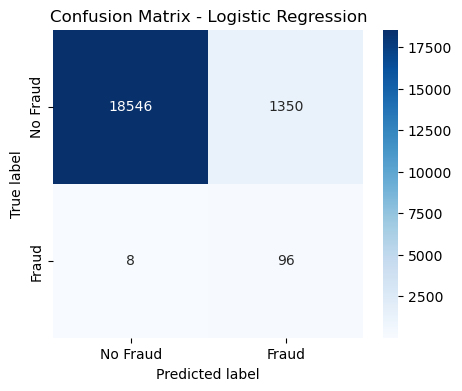

In [30]:
# without grid search cv 
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, recall_score
from sklearn.metrics import roc_curve, auc

pipe_non_tree.fit(X_train, y_train)
# Generate class predictions (0 or 1)
# Used for confusion matrix, recall, precision, and F1-score
y_pred = pipe_non_tree.predict(X_test)
# Generate predicted probabilities for the positive class (fraud = 1)
y_proba = pipe_non_tree.predict_proba(X_test)[:, 1]
# Compute recall score
# Recall is critical in fraud detection as it measures # how many actual fraud cases are correctly identified
print('recall_score', recall_score(y_test, y_pred))
 

#Print detailed classification report
# Includes precision, recall, F1-score, and support
# Helps understand trade-offs between false positives and false negatives
print(classification_report(y_test, y_pred))

#Compute ROC-AUC score
# Evaluates model’s ability to separate fraud vs non-fraud
# Independent of classification threshold
print("ROC_AUC:", roc_auc_score(y_test, y_proba))

# ROC Curve points
fpr, tpr, roc_thresholds = roc_curve(y_test, y_proba)

# AUC value (same as roc_auc_score)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], linestyle='--', label='Random classifier')

plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR / Recall)')
plt.title('ROC Curve - Logistic Regression')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()
# PR_AUC
# PR-AUC is preferred over ROC-AUC for fraud detection because it evaluates
# precision–recall performance on the minority (fraud) class in imbalanced data.
pr_auc = average_precision_score(y_test, y_proba)
print("PR-AUC:", pr_auc)
# Generate confusion matrix
# Shows True Positives, False Positives, True Negatives, and False Negatives
cm = confusion_matrix(y_test, y_pred)

# Visualize confusion matrix using heatmap
# Makes error distribution easier to interpret
labels = ['No Fraud', 'Fraud']
plt.figure(figsize=(5,4))
sns.heatmap(cm,annot=True,fmt='d',cmap='Blues',xticklabels=labels,yticklabels=labels) #cmap='Reds'
#Label axes for clarity
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix - Logistic Regression')
plt.show()

#“The model outputs probabilities; the threshold converts probabilities into decisions.”

### Model Training — Tree Models (Decision Tree / Random Forest / XGBoost / LightGBM)

In [31]:
# for tree input pipline 
preprocess_tree = ColumnTransformer(
    transformers=[('num', 'passthrough',numeric_base)],remainder='drop')

## Decision Tree

In [32]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report,roc_auc_score,confusion_matrix,recall_score
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
dt= DecisionTreeClassifier(
    criterion="gini",
    max_depth=3,
    min_samples_split=10,
    min_samples_leaf=10,
    class_weight="balanced",
    random_state=42
)

dt_pipe = Pipeline(steps=[('preprocess', preprocess_tree),('model', dt)]) #('smote', SMOTE(sampling_strategy=0.10, random_state=42)),

Decision Tree – classification report
              precision    recall  f1-score   support

           0       1.00      0.96      0.98     19896
           1       0.09      0.88      0.17       104

    accuracy                           0.96     20000
   macro avg       0.55      0.92      0.57     20000
weighted avg       0.99      0.96      0.97     20000

Confusion matrix
[[19017   879]
 [   12    92]]
ROC_AUC: 0.9698456009712042


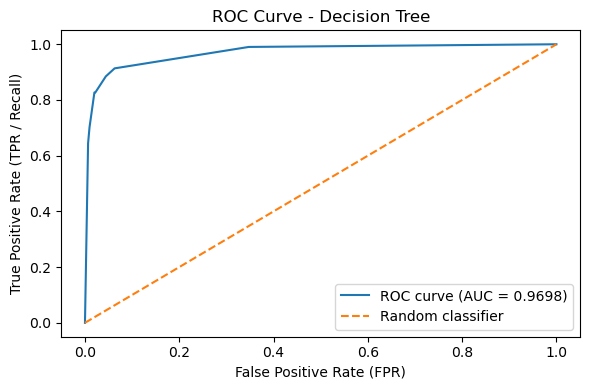

PR-AUC: 0.2647834213856895
recall_score 0.8846153846153846


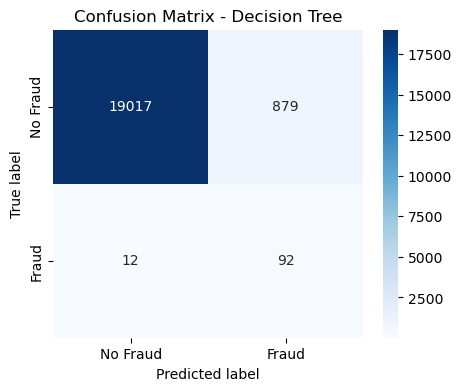

In [33]:
dt_pipe.fit(X_train, y_train)
y_pred_dt  = dt_pipe.predict(X_test)
y_proba_dt = dt_pipe.predict_proba(X_test)[:, 1] 

print("Decision Tree – classification report")
print(classification_report(y_test, y_pred_dt))

print("Confusion matrix")
print(confusion_matrix(y_test, y_pred_dt))

print("ROC_AUC:", roc_auc_score(y_test, y_proba_dt))
# ROC Curve points
fpr, tpr, roc_thresholds = roc_curve(y_test, y_proba_dt)

# AUC value (same as roc_auc_score)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], linestyle='--', label='Random classifier')

plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR / Recall)')
plt.title('ROC Curve - Decision Tree')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()
# PR_AUC
# PR-AUC is preferred over ROC-AUC for fraud detection because it evaluates
# precision–recall performance on the minority (fraud) class in imbalanced data.
pr_auc = average_precision_score(y_test, y_proba_dt)
print("PR-AUC:", pr_auc)
print('recall_score', recall_score(y_test, y_pred_dt))
cm = confusion_matrix(y_test, y_pred_dt)

labels = ['No Fraud', 'Fraud']
plt.figure(figsize=(5,4))
sns.heatmap(cm,annot=True,fmt='d',cmap='Blues',xticklabels=labels,yticklabels=labels)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix - Decision Tree')
plt.show()



## Random Forest

In [34]:

rf = RandomForestClassifier(
    n_estimators=300,             # try: 300, 500, 800
    max_depth=5,                 # try: None, 15, 20, 30
    min_samples_split=20,         # try: 10, 20, 50
    min_samples_leaf=10,          # try: 5, 10, 20
    max_features="sqrt",          # strong default
    class_weight="balanced_subsample",
    oob_score=True,               # optional
    n_jobs=-1,
    random_state=42
)
#('smote', SMOTE(sampling_strategy=0.10, random_state=42)),
rf_pipe = Pipeline(steps=[
    ('preprocess', preprocess_tree),('model', rf)])

=== Random Forest ===
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     19896
           1       0.18      0.92      0.30       104

    accuracy                           0.98     20000
   macro avg       0.59      0.95      0.64     20000
weighted avg       1.00      0.98      0.99     20000

ROC_AUC: 0.9921331307413938
PR-AUC: 0.6897746933644857
Confusion matrix:
 [[19456   440]
 [    8    96]]
recall_score 0.9230769230769231


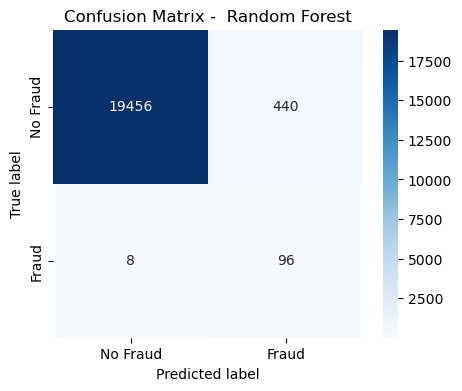

In [35]:
rf_pipe.fit(X_train, y_train)

y_pred_rf  = rf_pipe.predict(X_test)
y_proba_rf = rf_pipe.predict_proba(X_test)[:, 1]

print("=== Random Forest ===")
print(classification_report(y_test, y_pred_rf))
print("ROC_AUC:", roc_auc_score(y_test, y_proba_rf))
# ROC Curve points
# fpr, tpr, roc_thresholds = roc_curve(y_test, y_proba_rf)

# # AUC value (same as roc_auc_score)
# roc_auc = auc(fpr, tpr)

# plt.figure(figsize=(6,4))
# plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.4f})')
# plt.plot([0, 1], [0, 1], linestyle='--', label='Random classifier')
# plt.xlabel('False Positive Rate (FPR)')
# plt.ylabel('True Positive Rate (TPR / Recall)')
# plt.title('ROC Curve -  Random Forest')
# plt.legend(loc='lower right')
# plt.tight_layout()
# plt.show()

# PR_AUC
# PR-AUC is preferred over ROC-AUC for fraud detection because it evaluates
# precision–recall performance on the minority (fraud) class in imbalanced data.
pr_auc = average_precision_score(y_test, y_proba_rf)
print("PR-AUC:", pr_auc)

print("Confusion matrix:\n", confusion_matrix(y_test, y_pred_rf))
print('recall_score', recall_score(y_test, y_pred_rf))
cm = confusion_matrix(y_test, y_pred_rf)

labels = ['No Fraud', 'Fraud']
plt.figure(figsize=(5,4))
sns.heatmap(cm,annot=True,fmt='d',cmap='Blues',xticklabels=labels,yticklabels=labels)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix -  Random Forest')
plt.show()

In [36]:
#!pip install xgboost

## Xgboost

              precision    recall  f1-score   support

           0       1.00      0.99      0.99     19896
           1       0.24      0.89      0.38       104

    accuracy                           0.99     20000
   macro avg       0.62      0.94      0.69     20000
weighted avg       1.00      0.99      0.99     20000

ROC_AUC: 0.9950391072036128


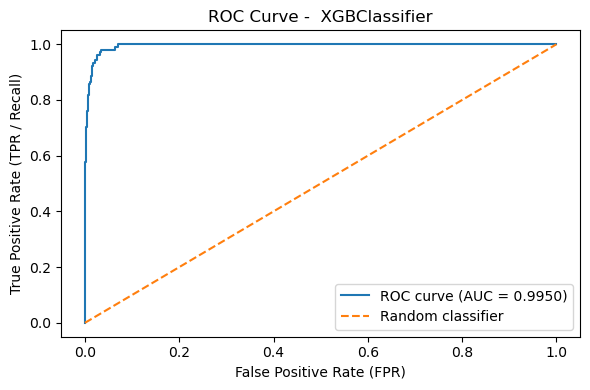

PR-AUC: 0.7078075800618677
Recall: 0.8942307692307693


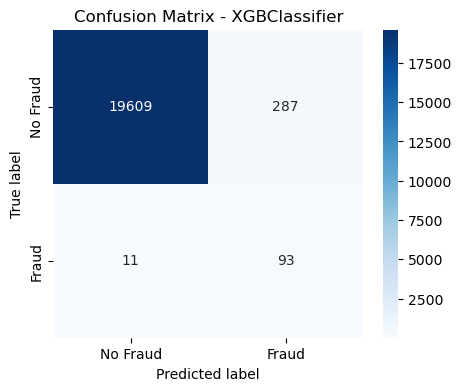

In [37]:

from xgboost import XGBClassifier

pos_weight = (y_train == 0).sum() / (y_train == 1).sum()


xgb = XGBClassifier(
    # ---- core ----
    n_estimators=600,          # ↓ fewer trees (MOST IMPORTANT)
    learning_rate=0.05,        # slightly higher LR → fewer trees needed

    # ---- complexity control ----
    max_depth=2,               # ↓ strongest anti-overfit
    min_child_weight=100,      # ↑ prevents rare-pattern memorization
    gamma=1.5,                 # ↑ split only if meaningful

    # ---- randomness ----
    subsample=0.6,
    colsample_bytree=0.6,

    # ---- regularization ----
    reg_alpha=10.0,            # strong L1
    reg_lambda=30.0,           # strong L2

    # ---- imbalance handling ----
    scale_pos_weight=pos_weight * 0.25,  # less aggressive → better PR-AUC

    # ---- misc ----
    tree_method="hist",
    eval_metric="aucpr",
    random_state=42,
    n_jobs=-1
)


#scale_pos_weight=10,
#('smote', SMOTE(sampling_strategy=0.10, random_state=42)),
xgb_pipe = Pipeline(steps=[
    ('preprocess', preprocess_tree),
    ('model', xgb)
])

xgb_pipe.fit(X_train, y_train)

y_pred_xgb = xgb_pipe.predict(X_test)
y_proba_xgb = xgb_pipe.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred_xgb))
print("ROC_AUC:", roc_auc_score(y_test, y_proba_xgb))
# ROC Curve points
fpr, tpr, roc_thresholds = roc_curve(y_test, y_proba_xgb)

# AUC value (same as roc_auc_score)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], linestyle='--', label='Random classifier')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR / Recall)')
plt.title('ROC Curve -  XGBClassifier')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

# PR_AUC
# PR-AUC is preferred over ROC-AUC for fraud detection because it evaluates
# precision–recall performance on the minority (fraud) class in imbalanced data.
pr_auc = average_precision_score(y_test, y_proba_xgb)
print("PR-AUC:", pr_auc)

print("Recall:", recall_score(y_test, y_pred_xgb))
cm = confusion_matrix(y_test, y_pred_xgb)

labels = ['No Fraud', 'Fraud']
plt.figure(figsize=(5,4))
sns.heatmap(cm,annot=True,fmt='d',cmap='Blues',xticklabels=labels,yticklabels=labels)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix - XGBClassifier')
plt.show()

                          feature        gain
8                num__amt_mean_20  697.863464
4                    num__amt_log  633.682007
6                   num__is_night  585.163696
9          num__amt_vs_mean_ratio  166.084549
1                    num__tr_hour  150.724991
0                   num__city_pop   75.769821
5                 num__is_weekend   73.937820
2                        num__age   67.338608
7              num__txns_last_24h   58.440609
3  num__distance_cust_merchant_km   57.128834


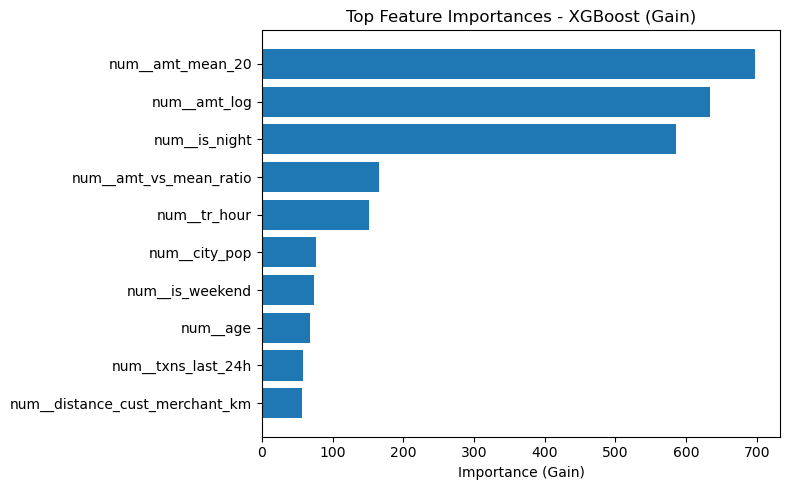

In [47]:
# import pandas as pd
# import matplotlib.pyplot as plt

# # get trained XGBoost model from pipeline
# xgb_model = xgb_pipe.named_steps["model"]

# # get feature names after preprocessing
# feature_names = xgb_pipe.named_steps["preprocess"].get_feature_names_out()

# # get importance scores (GAIN is best for trees)
# importance = xgb_model.get_booster().get_score(importance_type="gain")

# # convert to DataFrame
# imp_df = pd.DataFrame({
#     "feature": feature_names,
#     "importance": [importance.get(f, 0) for f in feature_names]
# })

# # sort
# imp_df = imp_df.sort_values(by="importance", ascending=False)

# print(imp_df.head(15))
import pandas as pd
import matplotlib.pyplot as plt

xgb_model = xgb_pipe.named_steps["model"]
feature_names = xgb_pipe.named_steps["preprocess"].get_feature_names_out()

# XGBoost gives importances as {"f0": ..., "f1": ...}
score = xgb_model.get_booster().get_score(importance_type="gain")

# map f0 -> feature_names[0], f1 -> feature_names[1], ...
imp = []
for k, v in score.items():
    idx = int(k[1:])              # "f12" -> 12
    imp.append((feature_names[idx], v))

imp_df = pd.DataFrame(imp, columns=["feature", "gain"]).sort_values("gain", ascending=False)

print(imp_df.head(20))

# plot top 15
top_n = 15
plt.figure(figsize=(8,5))
plt.barh(imp_df.head(top_n)["feature"], imp_df.head(top_n)["gain"])
plt.gca().invert_yaxis()
plt.xlabel("Importance (Gain)")
plt.title("Top Feature Importances - XGBoost (Gain)")
plt.tight_layout()
plt.show()

In [38]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
threshold = 0.20
# y_pred_lgb  = lgbm_pipe.predict(X_test)
# y_proba_lgb = lgbm_pipe.predict_proba(X_test)[:, 1]

y_pred = (y_proba_xgb >= threshold).astype(int)

tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

print("Threshold:", threshold)
print("Fraud Recall (catch rate):", recall_score(y_test, y_pred))
print("Fraud Precision:", precision_score(y_test,y_pred))
print("Fraud F1:", f1_score(y_test, y_pred))
print("TP (fraud caught):", tp)
print("FN (fraud missed):", fn)
print("FP (false alerts):", fp)
print("Alert rate:", (tp+fp)/len(y_test))

Threshold: 0.2
Fraud Recall (catch rate): 0.9807692307692307
Fraud Precision: 0.12577065351418001
Fraud F1: 0.22295081967213115
TP (fraud caught): 102
FN (fraud missed): 2
FP (false alerts): 709
Alert rate: 0.04055


## Cross Validation

In [40]:
import numpy as np
from sklearn.model_selection import StratifiedKFold, cross_validate

# ------------------------
# CV setup
# ------------------------
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scoring = {
    "pr_auc": "average_precision",
    "recall": "recall"
}

# ------------------------
# Models to evaluate
# ------------------------
models_to_check = {
    "Logistic Regression + SMOTE": pipe_non_tree,
    "Decision Tree": dt_pipe,
    "Random Forest": rf_pipe,
    "XGBoost": xgb_pipe
}

# ------------------------
# CV report function
# ------------------------
def cv_report(name, model):
    print("\n" + "="*60)
    print(f"Cross-Validation Report: {name}")

    res = cross_validate(
        model,
        X_train, y_train,
        cv=cv,
        scoring=scoring,
        n_jobs=-1,
        return_train_score=True
    )

    tr_pr, va_pr = res["train_pr_auc"].mean(), res["test_pr_auc"].mean()
    tr_rec, va_rec = res["train_recall"].mean(), res["test_recall"].mean()

    print(f"PR-AUC  | Train: {tr_pr:.3f} | Validation: {va_pr:.3f}")
    print(f"Recall  | Train: {tr_rec:.3f} | Validation: {va_rec:.3f}")

    # ---- PR-AUC assessment ----
    pr_gap = tr_pr - va_pr
    if pr_gap > 0.05:
        print("PR-AUC Assessment: Overfitting")
    elif tr_pr < 0.35 and va_pr < 0.30:
        print("PR-AUC Assessment: Underfitting")
    else:
        print("PR-AUC Assessment: Acceptable")

    # ---- Recall assessment ----
    rec_gap = tr_rec - va_rec
    if rec_gap > 0.08:
        print("Recall Assessment: Overfitting")
    elif va_rec < 0.60:
        print("Recall Assessment: Underfitting")
    else:
        print("Recall Assessment: Acceptable")

# ------------------------
# Run CV for all models
# ------------------------
for name, model in models_to_check.items():
    try:
        cv_report(name, model)
    except Exception as e:
        print("\n" + "="*60)
        print(f"CV failed for {name}")
        print(e)


Cross-Validation Report: Logistic Regression + SMOTE
PR-AUC  | Train: 0.216 | Validation: 0.229
Recall  | Train: 0.881 | Validation: 0.873
PR-AUC Assessment: Underfitting
Recall Assessment: Acceptable

Cross-Validation Report: Decision Tree
PR-AUC  | Train: 0.277 | Validation: 0.272
Recall  | Train: 0.869 | Validation: 0.839
PR-AUC Assessment: Underfitting
Recall Assessment: Acceptable

Cross-Validation Report: Random Forest
PR-AUC  | Train: 0.758 | Validation: 0.674
Recall  | Train: 0.920 | Validation: 0.851
PR-AUC Assessment: Overfitting
Recall Assessment: Acceptable

Cross-Validation Report: XGBoost
PR-AUC  | Train: 0.726 | Validation: 0.666
Recall  | Train: 0.932 | Validation: 0.854
PR-AUC Assessment: Overfitting
Recall Assessment: Acceptable


In [41]:
recall_log_reg   = recall_score(y_test, y_pred)
recall_dt        = recall_score(y_test, y_pred_dt)
recall_rf        = recall_score(y_test, y_pred_rf)
recall_xgb       = recall_score(y_test, y_pred_xgb)


                 model    recall
0  Logistic Regression  0.980769
1        Decision Tree  0.884615
2        Random Forest  0.923077
3              XGBoost  0.894231


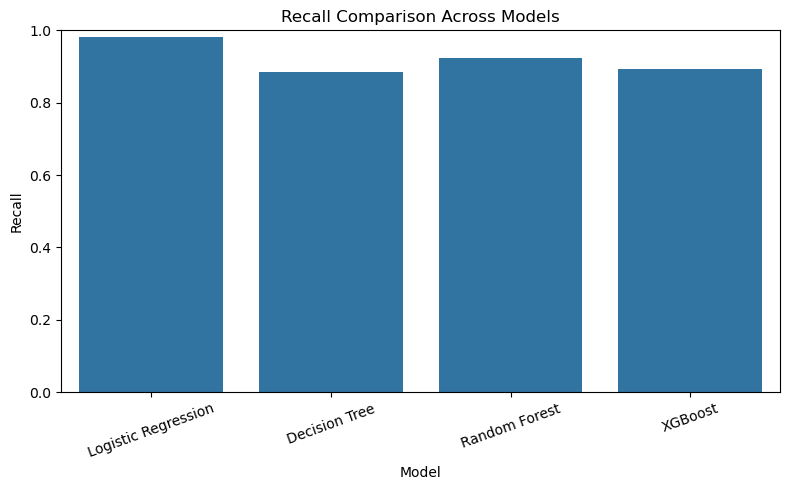

In [43]:
recall_data = {"model": [ "Logistic Regression", "Decision Tree", "Random Forest", "XGBoost"],
    "recall": [ recall_log_reg, recall_dt, recall_rf, recall_xgb]
}

recall_df = pd.DataFrame(recall_data)

print(recall_df)

# bar plot
plt.figure(figsize=(8, 5))
sns.barplot(data=recall_df, x="model", y="recall")

plt.ylim(0, 1)  # recall is between 0 and 1
plt.title("Recall Comparison Across Models")
plt.ylabel("Recall")
plt.xlabel("Model")
plt.xticks(rotation=20)
plt.tight_layout()
plt.show()

In [44]:
prauc_log_reg = average_precision_score(y_test, y_proba)
prauc_dt      = average_precision_score(y_test, y_proba_dt)
prauc_rf      = average_precision_score(y_test, y_proba_rf)
prauc_xgb     = average_precision_score(y_test, y_proba_xgb)

                 model    pr_auc
0  Logistic Regression  0.291068
1        Decision Tree  0.264783
2        Random Forest  0.689775
3              XGBoost  0.707808


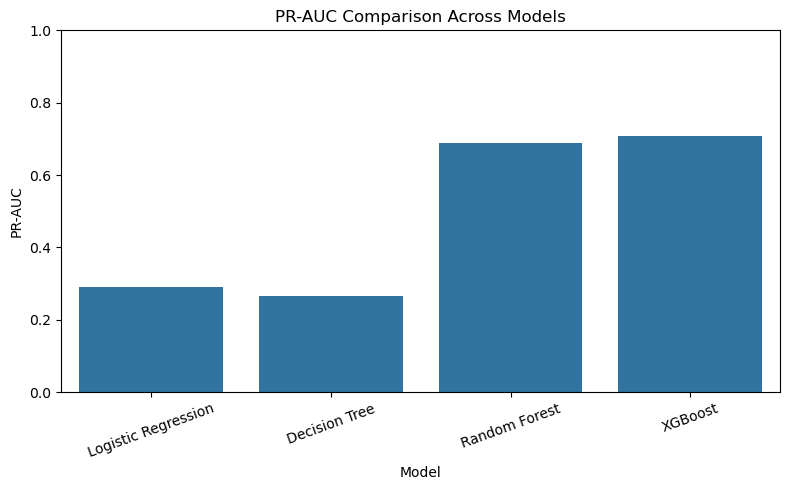

In [45]:
prauc_data = {
    "model": ["Logistic Regression", "Decision Tree", "Random Forest", "XGBoost"],
    "pr_auc": [prauc_log_reg, prauc_dt, prauc_rf, prauc_xgb]
}

prauc_df = pd.DataFrame(prauc_data)
print(prauc_df)
plt.figure(figsize=(8, 5))
sns.barplot(data=prauc_df, x="model", y="pr_auc")

plt.ylim(0, 1)
plt.title("PR-AUC Comparison Across Models")
plt.ylabel("PR-AUC")
plt.xlabel("Model")
plt.xticks(rotation=20)
plt.tight_layout()
plt.show()

In [48]:
cv_results = pd.DataFrame({
    "model": [
        "Logistic Regression + SMOTE",
        "Decision Tree",
        "Random Forest",
        "XGBoost"
    ],
    "train_recall": [0.881, 0.869, 0.920, 0.932],
    "val_recall":   [0.873, 0.839, 0.851, 0.854],
    "train_prauc":  [0.216, 0.277, 0.758, 0.726],
    "val_prauc":    [0.229, 0.272, 0.674, 0.666]
})

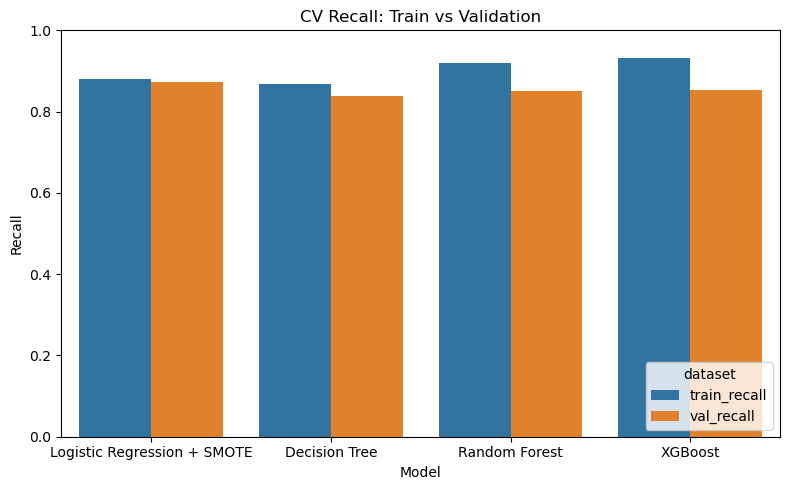

In [52]:
recall_df = cv_results.melt(
    id_vars="model",
    value_vars=["train_recall", "val_recall"],
    var_name="dataset",
    value_name="recall"
)

plt.figure(figsize=(8,5))
sns.barplot(data=recall_df, x="model", y="recall", hue="dataset")

plt.ylim(0, 1)
plt.title("CV Recall: Train vs Validation")
plt.xlabel("Model")
plt.ylabel("Recall")
plt.legend(title="dataset", loc="lower right")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

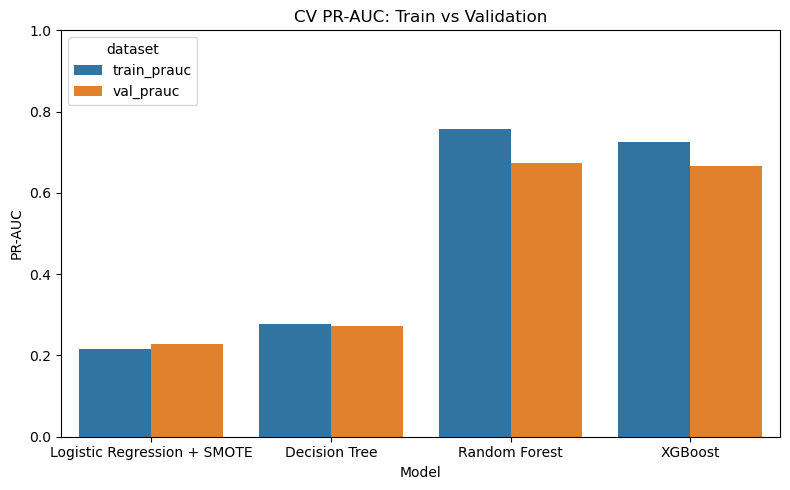

In [54]:
prauc_df = cv_results.melt(
    id_vars="model",
    value_vars=["train_prauc", "val_prauc"],
    var_name="dataset",
    value_name="pr_auc"
)

plt.figure(figsize=(8,5))
sns.barplot(data=prauc_df, x="model", y="pr_auc", hue="dataset")

plt.ylim(0, 1)
plt.title("CV PR-AUC: Train vs Validation")
plt.xlabel("Model")
plt.ylabel("PR-AUC")
plt.legend(title="dataset", loc="upper left")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()